# Mask Attention Visualization Demo

This Demo is a visualization of the attention map of masked words and image regions. 

## Settings

The next two code cells are the settings of model and visualize method. 

We use `rosita-base.pkl` as the default ckpt. 

In [1]:
# -------------------------------------------------------- 
 # ROSITA
 # Licensed under The Apache License 2.0 [see LICENSE for details] 
 # Written by Yuhao Cui and Tong-An Luo
 # -------------------------------------------------------- 

# set current work dir
import os
os.chdir('../')
os.getcwd()
# make sure the current work dir is the root 'rosita'.

'/home/luota/milvlg/vlp/rosita_gh/rosita'

In [2]:
import sys
sys.path.append('rosita/')
import torch, cv2, yaml, random, copy
import torch.nn.functional as F
import numpy as np
from rosita.config.cfg import Cfg
from demo_maskatt import Net, DataSet
import matplotlib.pyplot as plt
from pylab import ylim

%matplotlib inline

# set display defaults
# plt.rcParams['figure.figsize'] = (9, 16)
# plt.figure(figsize=(10, 10))
# plt.subplots_adjust(hspace=2, wspace=2)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# set config
config_file = 'configs/demo-maskatt.yaml'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
class Arg():
    def __init__(self):
        self.NODE_SIZE = 1
args = Arg()
__C = Cfg(world_size=1, args=args)
__C.CKPT_FILE = 'ckpts/rosita-base.pkl' # we use rosita-base.pkl as the default ckpt
__C.BERT_VOCAB_PATH = 'rosita/utils/bert_vocabs/vocab.txt'
__C.PAD_MAX = {'text': 20, 'image': 36}

# set random seed
torch.manual_seed(__C.SEED)
torch.cuda.manual_seed(__C.SEED)
torch.cuda.manual_seed_all(__C.SEED)
np.random.seed(__C.SEED)
random.seed(__C.SEED)
torch.backends.cudnn.benchmark = True
torch.set_printoptions(profile="full")
np.set_printoptions(threshold=1e9)

# set dataset
dataset = DataSet(__C)

# Load Checkpoint and set model
ckpt_path = __C.CKPT_FILE
ckpt = torch.load(ckpt_path)
init_map = {'vocab_size': dataset.vocab_size}
net = Net(__C, init_map)

net.to('cuda:0')

for weight_key in __C.CKPT_SAVE_MAP:
    if weight_key not in ['net_optim', 'epoch']:
        getattr(net, weight_key).load_state_dict(ckpt[__C.CKPT_SAVE_MAP[weight_key]])

net.eval()

def show_maskatt_img(img_filename, mask_side, mask_id_list, text_id=None, text=None):    
    with torch.no_grad():
        text_input_ids, text_mask, text_mlm_label_ids, \
        imgfeat_input, imgfeat_mask, imgfeat_bbox, \
        text_len, boxes = dataset.get_item(img_filename, mask_side, mask_id_list, text_id, text)

        text_input_ids_batch = text_input_ids.to('cuda:0').unsqueeze(0)
        text_mask_batch = text_mask.to('cuda:0').unsqueeze(0)
        imgfeat_input_batch = imgfeat_input.to('cuda:0').unsqueeze(0)
        imgfeat_mask_batch = imgfeat_mask.to('cuda:0').unsqueeze(0)
        imgfeat_bbox_batch = imgfeat_bbox.to('cuda:0').unsqueeze(0)

        net_input = (text_input_ids_batch, text_mask_batch, imgfeat_input_batch, imgfeat_mask_batch, imgfeat_bbox_batch)
        net_output = net(net_input)

        scores_out_list = net_output

        text_label = [dataset.tokenizer.ids_to_tokens[t.item()] for t in text_mlm_label_ids][1: 1 + text_len]
        img_root_path = 'demo/images/'
        img_path = img_root_path + img_filename
        print(f'image_path: {img_path}')

        def att_text(text_lbl, msk_ids):
            for msk_id in msk_ids:
                text_lbl[msk_id] = '|[{}]|'.format(text_lbl[msk_id])
            text_att = ''
            for i in range(len(text_lbl)):
                if i == 0:
                    text_att += text_lbl[i]
                elif text_lbl[i].startswith('#'):
                    text_att += text_lbl[i].replace('#', '')
                else:
                    text_att += ' ' + text_lbl[i]
            return text_att

        if mask_side == 'text':
            weights_list = []
            for idx in mask_id_list:
                scores = copy.deepcopy(scores_out_list[-1][0, :, idx + 1, -36:].sum(-2))
                weights = F.softmax(scores, dim=-1).numpy()
                weights_list.append(weights)

            text_att = att_text(copy.deepcopy(text_label), mask_id_list)
            print(text_att)
            plt.figure(figsize=(6*len(weights_list), 6))
            for weight_id, weights in enumerate(weights_list):
                masked = text_label[mask_id_list[weight_id]] if len(mask_id_list) else None
                img_att = cv2.imread(img_path)
                Vv = 180.
                max_imgfeat = 36
                mask = np.zeros_like(img_att[:, :, 2], dtype=np.float32)
                for ix, box in enumerate(boxes):
                    if ix == max_imgfeat:
                        break
                    x1 = int(box[0])
                    y1 = int(box[1])
                    x2 = int(box[2])
                    y2 = int(box[3])
                    mask[y1:y2, x1:x2] = mask[y1:y2, x1:x2] + weights[ix]
                mask = (mask - np.min(mask)) / (np.max(mask) - np.min(mask))
                mask = np.power(mask, 0.3)
                picHSV = cv2.cvtColor(img_att, cv2.COLOR_BGR2HSV).astype(np.float32)
                picHSV[:, :, 2] = picHSV[:, :, 2] - Vv
                picHSV[:, :, 2] = picHSV[:, :, 2] + mask * Vv
                picHSV[:, :, 2][picHSV[:, :, 2] < 0] = 0
                picHSV[:, :, 2][picHSV[:, :, 2] > 250] = 250
                img_att = cv2.cvtColor(picHSV.astype(np.uint8), cv2.COLOR_HSV2RGB)
                plt.subplot(1, len(weights_list), weight_id+1)
                plt.title('masked word: {}'.format(masked))
                plt.imshow(img_att)
                plt.axis('off')
            plt.show()
        
        else:
            img_att = cv2.imread(img_path)
            img_att = cv2.cvtColor(img_att.astype(np.uint8), cv2.COLOR_BGR2RGB)

            weights_list = []
            for idx in mask_id_list:
                scores = copy.deepcopy(scores_out_list[-1][0, :, 20 + idx, 1: 1 + text_len].sum(-2))
                weights = F.softmax(scores, dim=-1).numpy()
                weights_list.append(weights)
            plt.figure(figsize=(15*len(weights_list)+1, 6))
            plt.subplot(1, len(weights_list)+1, 1)
            plt.imshow(img_att)
            plt.axis('off')
            for ix, idx in enumerate(mask_id_list):
                bbox = boxes[idx]
                if bbox[0] == 0:
                    bbox[0] = 1
                if bbox[1] == 0:
                    bbox[1] = 1
                box_name = 'maskid:{} bboxid:{}'.format(ix, idx)
                plt.gca().add_patch(
                    plt.Rectangle((bbox[0], bbox[1]),
                                bbox[2] - bbox[0],
                                bbox[3] - bbox[1], fill=False,
                                edgecolor='red', linewidth=2, alpha=0.5)
                        )
                plt.gca().text(bbox[0], bbox[1] - 2,
                            '%s' % (box_name),
                            bbox=dict(facecolor='blue', alpha=0.5),
                            fontsize=10, color='white')
            for weight_id, weights in enumerate(weights_list):
                plt.subplot(1, len(weights_list)+1, weight_id+2)
                plt.title('masked id: {}'.format(weight_id))
                plt.bar(range(len(text_label)), weights, width=0.5, fc='g', tick_label=text_label)
                plt.xticks(rotation=45)
                ylim([0., 1.])
            plt.show()
        

The `show_maskatt_img` function is the core for visualization. As stated in our paper, we first extract the multi-head attention maps from the last MSA block of the pretrained model, then perform element-wise addition over different heads to obtain one attention map, and finally visualize the row(s) of specific attention map with respect to different masked token(s).

We provide some paired image-text examples from the MSCOCO validation set to run the following visualizations, which are not used during the pretraining. For each image, we provide pre-extracted `bottom-up-attention` region features (with 36 detected objects). Ecah image is associated with five captions. 

The images are in the `demo/images` folder. Here are the file names of these images:
- COCO_val2014_000000058350.jpg
- COCO_val2014_000000124629.jpg
- COCO_val2014_000000268556.jpg
- COCO_val2014_000000399879.jpg
- COCO_val2014_000000409241.jpg
- COCO_val2014_000000437564.jpg
- COCO_val2014_000000504810.jpg
- COCO_val2014_000000562150.jpg

And their corresponding extracted region features and captions are stored in a `*.jpg.npz` homonymic file in the folder `demo/features`. 

To use `show_maskatt_img`, you need to specify the input `img_name`, which is one of these eight image names, `mask_side` (`'text'` or `'img'`), `mask_id`, a list of masked word/region ids, `text_id` or `text`. 

When masked one word (region), input one masking index in the `mask_id` field, and when masked multiple words (regions), just input a list of masking indices in the `mask_id` field. 

The `text_id` should be within `[0, 4]`, corresponding to one of the five captions of the given image. If you want to provide caption for the image by yourself, you can use the `text` field to input the custom caption.

Now, let's start!

## Mask One Word

Here are the examples of visualizing attention map when masked one word. 

image_path: demo/images/COCO_val2014_000000124629.jpg
an older |[woman]| standing next to two children


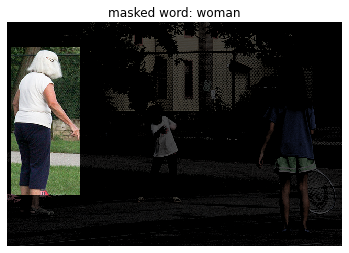

In [3]:
img_name = 'COCO_val2014_000000124629.jpg'
text_id = 0
mask_side = 'text'
mask_id = [2]
show_maskatt_img(img_name, mask_side, mask_id, text_id)

image_path: demo/images/COCO_val2014_000000124629.jpg
an older woman standing next to two |[children]|


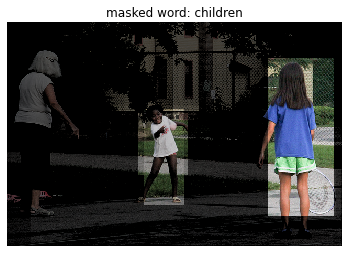

In [4]:
img_name = 'COCO_val2014_000000124629.jpg'
text_id = 0 
mask_side = 'text'
mask_id = [7]
show_maskatt_img(img_name, mask_side, mask_id, text_id)

## Mask Multiple Words

Here are the examples of visualizing attention map when masked multiple words. 

The text has multiple masked words, and each masked word has an attention map. 

In [5]:
img_name = 'COCO_val2014_000000124629.jpg'
text_id = 0
mask_side = 'text'
mask_id = [2, 7]
show_maskatt_img(img_name, mask_side, mask_id, text_id)

image_path: demo/images/COCO_val2014_000000124629.jpg
an older |[woman]| standing next to two |[children]|


image_path: demo/images/COCO_val2014_000000504810.jpg
a large meat |[sandwich]| with a side of |[fries]|


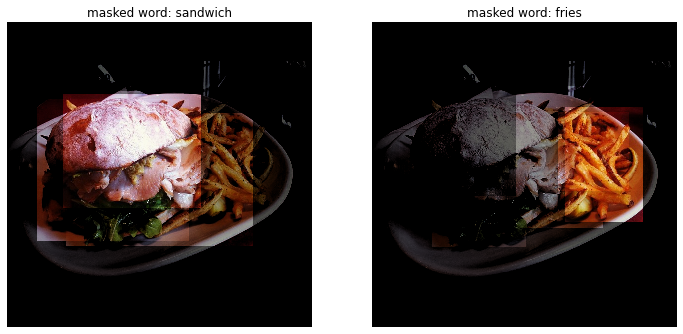

In [6]:
img_name = 'COCO_val2014_000000504810.jpg'
text_id = 1
mask_side = 'text'
mask_id = [3, 8]
show_maskatt_img(img_name, mask_side, mask_id, text_id)

image_path: demo/images/COCO_val2014_000000399879.jpg
a |[woman]| is sitting at a |[table]| wearing a robe while a |[man]| is cooking


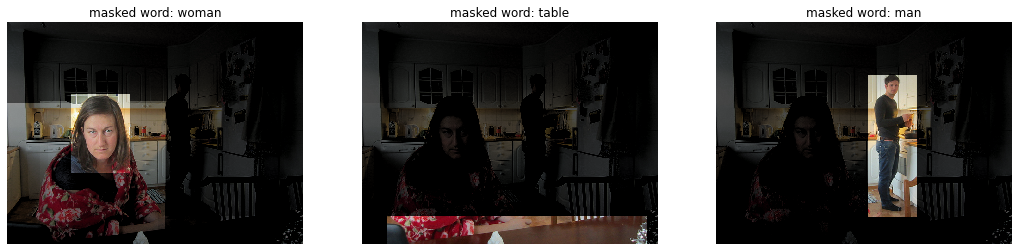

In [7]:
img_name = 'COCO_val2014_000000399879.jpg'
text_id = 3
mask_side = 'text'
mask_id = [1, 6, 12]
show_maskatt_img(img_name, mask_side, mask_id, text_id)

## Mask One Word with Custom Text

Here are the examples of visualizing attention map when masked one word with custom text.

image_path: demo/images/COCO_val2014_000000124629.jpg
a white hair old woman is watching a black girl catching |[tennis]| ball


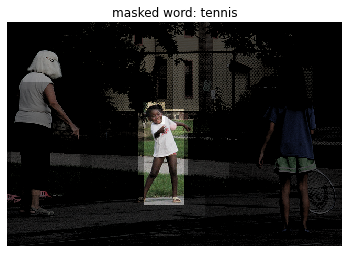

In [8]:
img_name = 'COCO_val2014_000000124629.jpg'
text = 'a white hair old woman is watching a black girl catching tennis ball'
mask_side = 'text'
mask_id = [11]
show_maskatt_img(img_name, mask_side, mask_id, text=text)

image_path: demo/images/COCO_val2014_000000124629.jpg
a white hair old |[woman]| is watching a black girl catching tennis ball


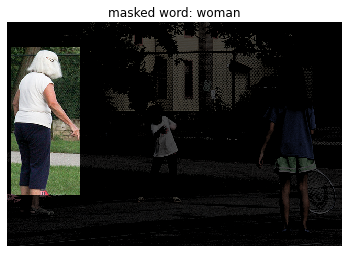

In [9]:
img_name = 'COCO_val2014_000000124629.jpg'
text = 'a white hair old woman is watching a black girl catching tennis ball'
mask_side = 'text'
mask_id = [4]
show_maskatt_img(img_name, mask_side, mask_id, text=text)

## Mask Multiple Words with Custom Text

Here is the example of visualizing attention map when masked multiple words with custom text.

image_path: demo/images/COCO_val2014_000000124629.jpg
a white hair old woman is watching two |[girls]| playing |[tennis]|


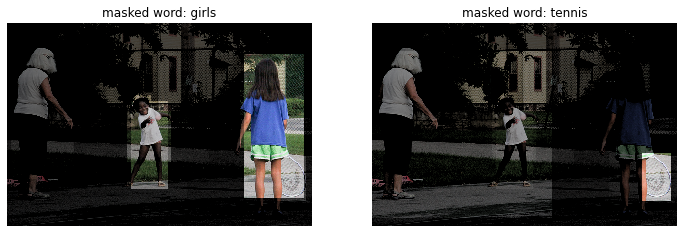

In [10]:
img_name = 'COCO_val2014_000000124629.jpg'
text = 'a white hair old woman is watching two girls playing tennis'
mask_side = 'text'
mask_id = [8, 10]
show_maskatt_img(img_name, mask_side, mask_id, text=text)

## Mask One Region

Here are the examples of visualizing attention map when masked one region.

image_path: demo/images/COCO_val2014_000000058350.jpg


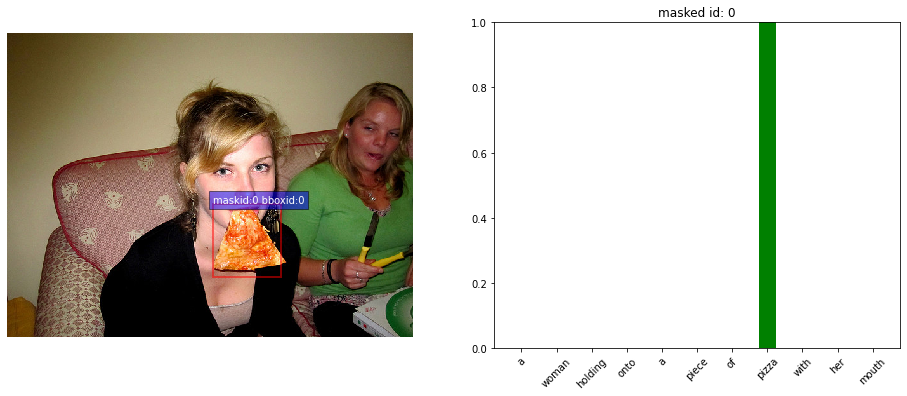

In [11]:
img_name = 'COCO_val2014_000000058350.jpg'
text_id = 3
mask_side = 'img'
mask_id = [0]
show_maskatt_img(img_name, mask_side, mask_id, text_id)

image_path: demo/images/COCO_val2014_000000437564.jpg


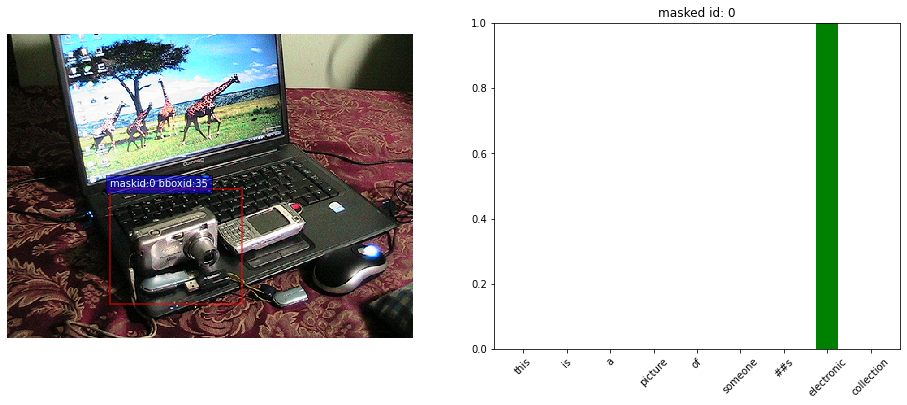

In [12]:
img_name = 'COCO_val2014_000000437564.jpg'
text_id = 1
mask_side = 'img'
mask_id = [35]
show_maskatt_img(img_name, mask_side, mask_id, text_id)

## Mask Multiple Regions

Here are the examples of visualizing attention map when masked multiple regions. 

The image feature has multiple masked region features, and each masked region has an attention map of text. 

image_path: demo/images/COCO_val2014_000000562150.jpg


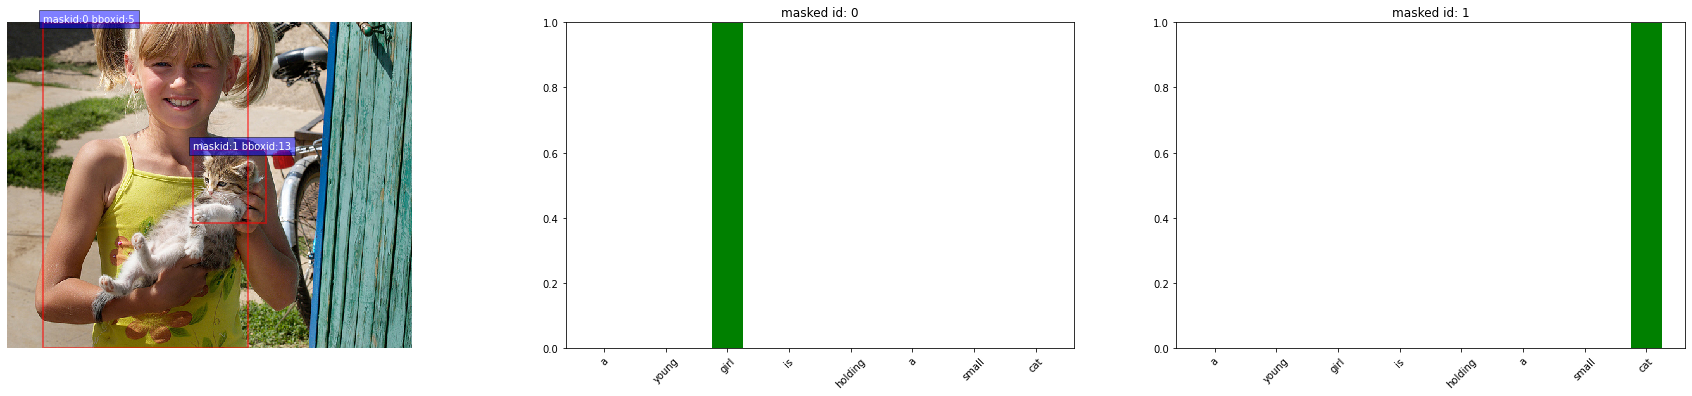

In [13]:
img_name = 'COCO_val2014_000000562150.jpg'
text_id = 2
mask_side = 'img'
mask_id = [5, 13]
show_maskatt_img(img_name, mask_side, mask_id, text_id)

In [14]:
img_name = 'COCO_val2014_000000268556.jpg'
text_id = 0
mask_side = 'img'
mask_id = [22, 28, 29]
show_maskatt_img(img_name, mask_side, mask_id, text_id)

image_path: demo/images/COCO_val2014_000000268556.jpg


## Mask One Region with Custom Text

Here is the example of visualizing attention map when masked one region with custom text.

In [15]:
img_name = 'COCO_val2014_000000058350.jpg'
text = 'a blonde is holding pizza on mouth'
mask_side = 'img'
mask_id = [0]
show_maskatt_img(img_name, mask_side, mask_id, text=text)

image_path: demo/images/COCO_val2014_000000058350.jpg


## Mask Multiple Regions with Custom Text

Here is the example of visualizing attention map when masked multiple regions.

image_path: demo/images/COCO_val2014_000000562150.jpg


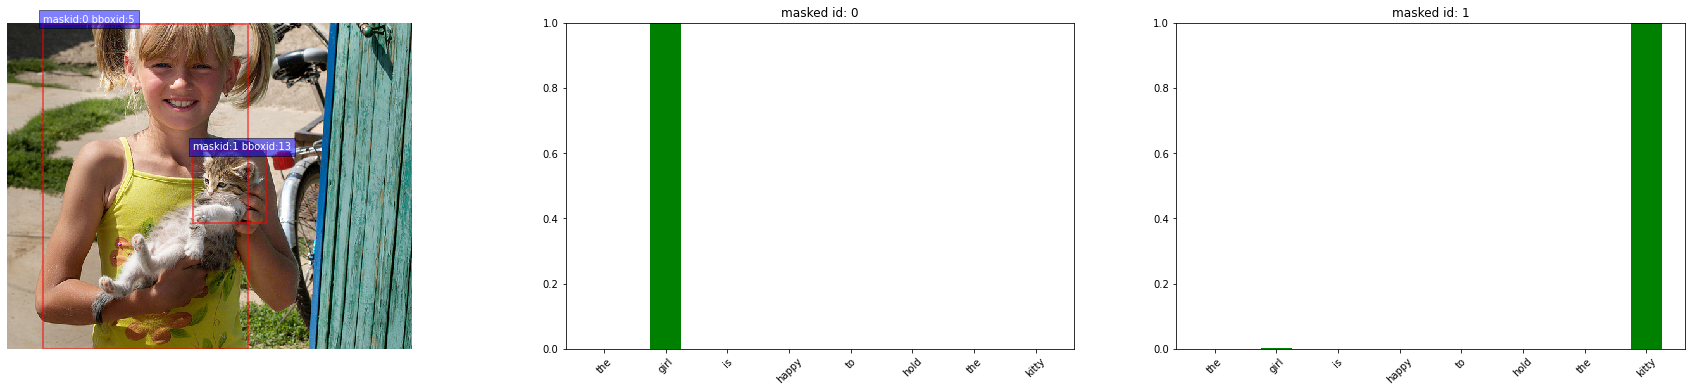

In [16]:
img_name = 'COCO_val2014_000000562150.jpg'
text = 'the girl is happy to hold the kitty'
mask_side = 'img'
mask_id = [5, 13]
show_maskatt_img(img_name, mask_side, mask_id, text=text)